**Installing & Importing the Required Libraries**

In [1]:
!pip install numpy==1.23.5 \
    scipy==1.10.1 \
    scikit-learn==1.2.2 \
    gensim==4.3.1 \
    nltk==3.8.1 \
    contractions==0.1.73 \
    matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import contractions

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Loading the Dataset**

In [2]:
if 'df' not in locals():  #Done to Repeat Uploading the Same File Again for new Runtime
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv(next(iter(uploaded)))

Saving AG News Classification Dataset.csv.zip to AG News Classification Dataset.csv.zip


**Analyzing the Original Dataset**

Dataset Shape: (7600, 3)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB
None

Sample Rows:


,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...



Class Distribution:


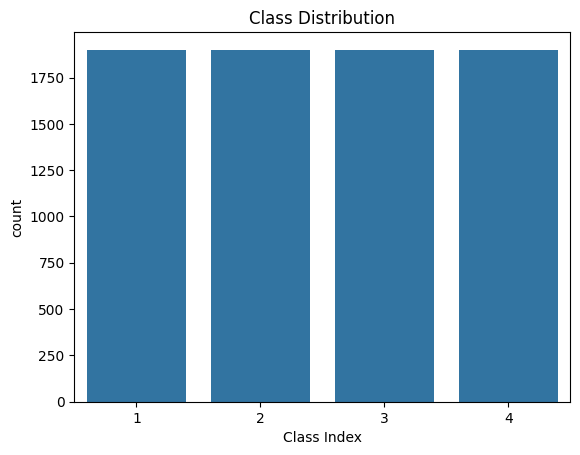


Average Text Lengths:
count    7600.000000
mean       30.963289
std         9.803751
min         4.000000
25%        25.000000
50%        30.000000
75%        36.000000
max       129.000000
Name: text_length, dtype: float64


In [3]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

print("\nSample Rows:")
display(df.head())

print("\nClass Distribution:")
sns.countplot(data=df, x='Class Index')
plt.title("Class Distribution")
plt.show()

print("\nAverage Text Lengths:")
df['text_length'] = df['Description'].apply(lambda x: len(str(x).split()))
print(df['text_length'].describe())

df['text'] = df['Title'] + ' ' + df['Description'] #Later Analysis

**Preprocessing the Data**

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_basic(text):
    text = re.sub(r'\W+', ' ', text.lower())  #Lowercasing
    tokens = nltk.word_tokenize(text) #Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  #Lemmatization
    return ' '.join(tokens)

def preprocess_advanced(text):
    text = text.lower()
    text = contractions.fix(text) #Expand English short-forms to full forms
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #Email Removal
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)  #Punctuation Removal
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]  #Lemmatization
    return ' '.join(tokens)

**Models Pipeline**

In [5]:
def run_pipeline(preprocess_func, method_label):
    df['clean_text'] = df['text'].apply(preprocess_func)

    X = df['clean_text']
    y = df['Class Index']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # TF-IDF
    tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    lr_tfidf = LogisticRegression(max_iter=1000)
    svm_tfidf = SVC()

    lr_tfidf.fit(X_train_tfidf, y_train)
    svm_tfidf.fit(X_train_tfidf, y_train)

    pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
    pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

    #Word2Vec
    train_tokens = [nltk.word_tokenize(t) for t in X_train]
    test_tokens = [nltk.word_tokenize(t) for t in X_test]

    w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

    def avg_vector(tokens, model, size):
        vecs = []
        for doc in tokens:
            vec = np.zeros(size)
            count = 0
            for word in doc:
                if word in model.wv:
                    vec += model.wv[word]
                    count += 1
            if count > 0:
                vec /= count
            vecs.append(vec)
        return np.array(vecs)

    X_train_w2v = avg_vector(train_tokens, w2v_model, 100)
    X_test_w2v = avg_vector(test_tokens, w2v_model, 100)

    lr_w2v = LogisticRegression(max_iter=1000)
    svm_w2v = SVC()

    lr_w2v.fit(X_train_w2v, y_train)
    svm_w2v.fit(X_train_w2v, y_train)

    pred_lr_w2v = lr_w2v.predict(X_test_w2v)
    pred_svm_w2v = svm_w2v.predict(X_test_w2v)

    def eval_metrics(y_true, y_pred):
        acc = np.mean(y_true == y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        return [acc, precision, recall, f1]

    return (
        pd.DataFrame([
            eval_metrics(y_test, pred_lr_tfidf),
            eval_metrics(y_test, pred_svm_tfidf),
            eval_metrics(y_test, pred_lr_w2v),
            eval_metrics(y_test, pred_svm_w2v),
        ], columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        index=[
            f'{method_label} | TF-IDF + LR',
            f'{method_label} | TF-IDF + SVM',
            f'{method_label} | W2V + LR',
            f'{method_label} | W2V + SVM',
        ]),
        lr_tfidf, svm_tfidf, X_test_tfidf,
        lr_w2v, svm_w2v, X_test_w2v,
        y_test
    )

**Running and Comparing Basic and Advance Preprocessing Strategies**

In [6]:
results_basic, lr_tfidf, svm_tfidf, X_test_tfidf, lr_w2v, svm_w2v, X_test_w2v, y_test = run_pipeline(preprocess_basic, "Basic")
results_advanced, lr_tfidf_e, svm_tfidf_e, X_test_tfidf_e, lr_w2v_e, svm_w2v_e, X_test_w2v_e, y_test_e = run_pipeline(preprocess_advanced, "Enhanced")

final_results = pd.concat([results_basic, results_advanced])
final_results

,Accuracy,Precision,Recall,F1-Score
Basic | TF-IDF + LR,0.890789,0.890261,0.890789,0.890310
Basic | TF-IDF + SVM,0.896053,0.895694,0.896053,0.895710
Basic | W2V + LR,0.637500,0.636158,0.637500,0.634878
Basic | W2V + SVM,0.567105,0.566571,0.567105,0.565357
Enhanced | TF-IDF + LR,0.888158,0.887667,0.888158,0.887782
Enhanced | TF-IDF + SVM,0.886184,0.886063,0.886184,0.885902
Enhanced | W2V + LR,0.611842,0.622364,0.611842,0.606321
Enhanced | W2V + SVM,0.424342,0.403312,0.424342,0.368472


**Visualization - Confusion Matrix**

In [7]:
def plot_confusion(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


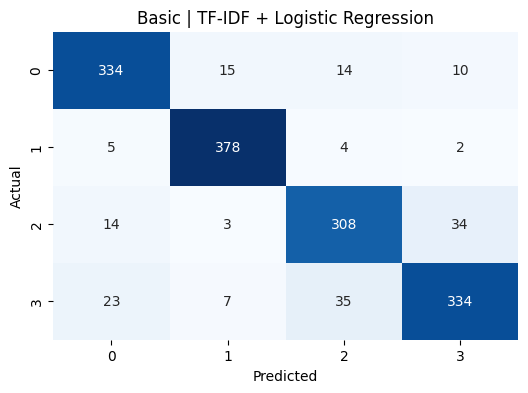

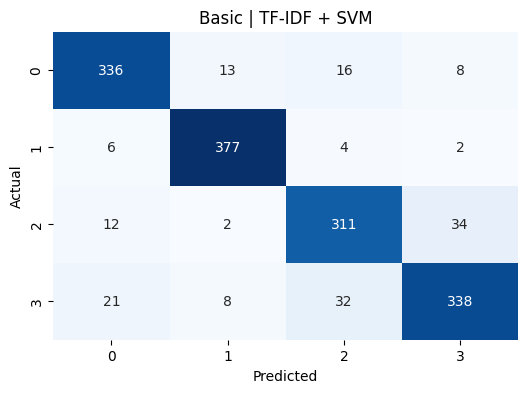

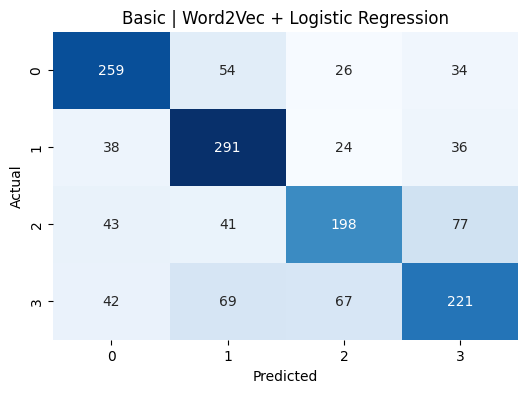

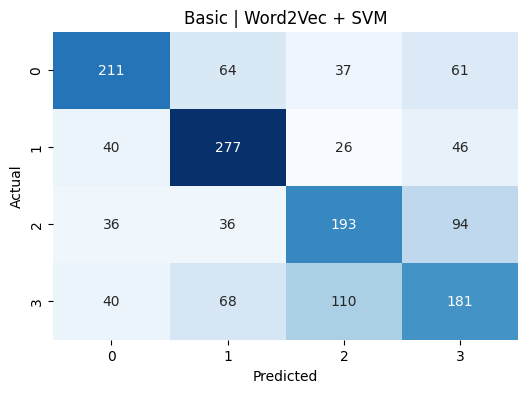

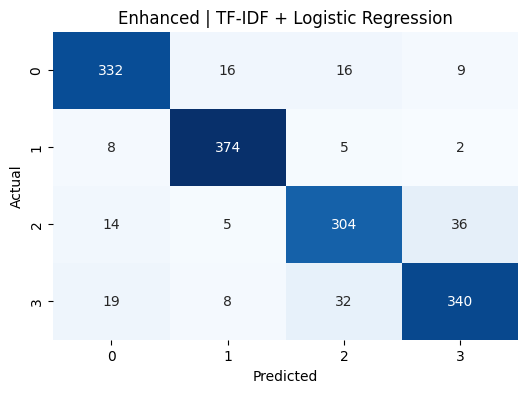

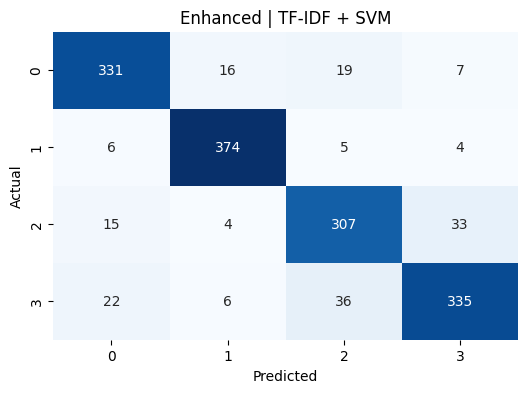

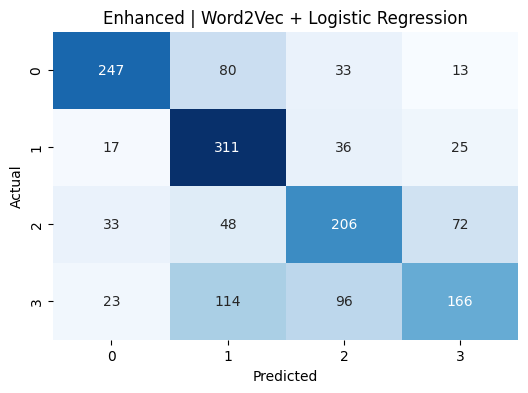

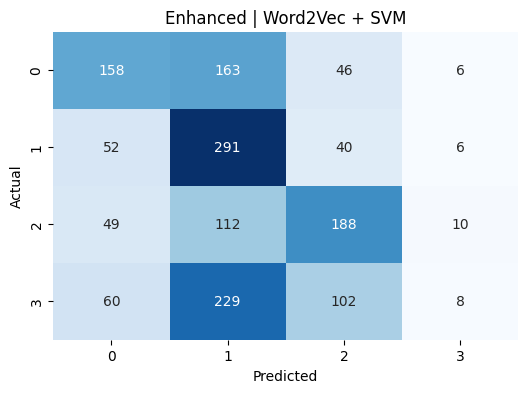

In [8]:
#TF-IDF (Basic)
plot_confusion(lr_tfidf, X_test_tfidf, y_test, "Basic | TF-IDF + Logistic Regression")
plot_confusion(svm_tfidf, X_test_tfidf, y_test, "Basic | TF-IDF + SVM")

#Word2Vec (Basic)
plot_confusion(lr_w2v, X_test_w2v, y_test, "Basic | Word2Vec + Logistic Regression")
plot_confusion(svm_w2v, X_test_w2v, y_test, "Basic | Word2Vec + SVM")

#TF-IDF (Enhanced)
plot_confusion(lr_tfidf_e, X_test_tfidf_e, y_test_e, "Enhanced | TF-IDF + Logistic Regression")
plot_confusion(svm_tfidf_e, X_test_tfidf_e, y_test_e, "Enhanced | TF-IDF + SVM")

#Word2Vec (Enhanced)
plot_confusion(lr_w2v_e, X_test_w2v_e, y_test_e, "Enhanced | Word2Vec + Logistic Regression")
plot_confusion(svm_w2v_e, X_test_w2v_e, y_test_e, "Enhanced | Word2Vec + SVM")

**Visualization - Bar Plots**

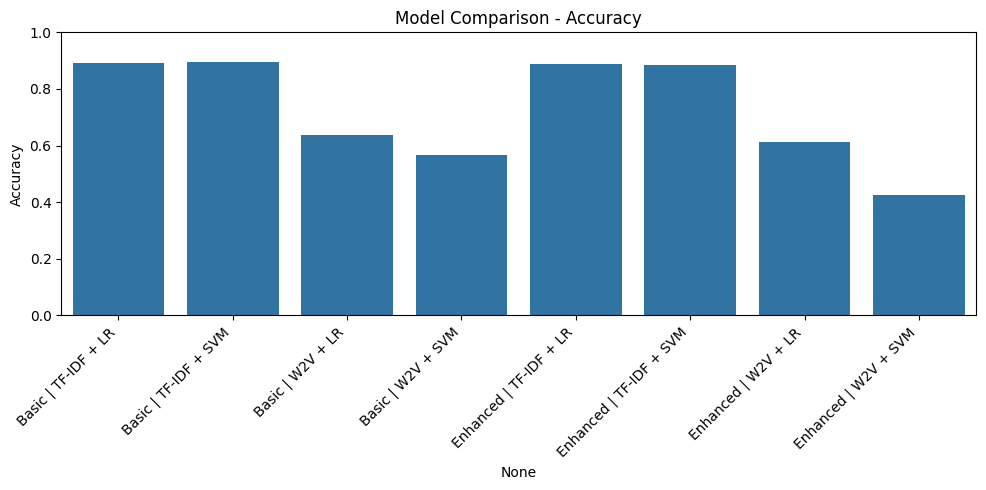

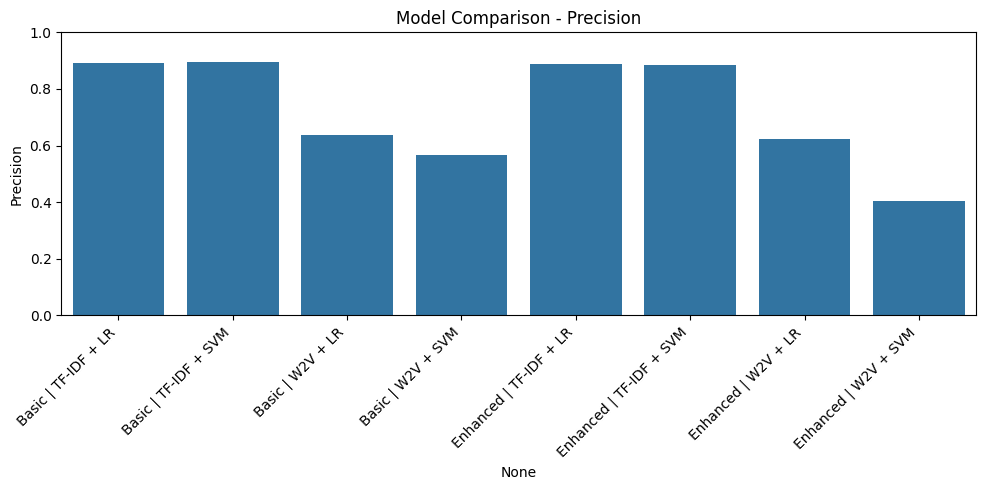

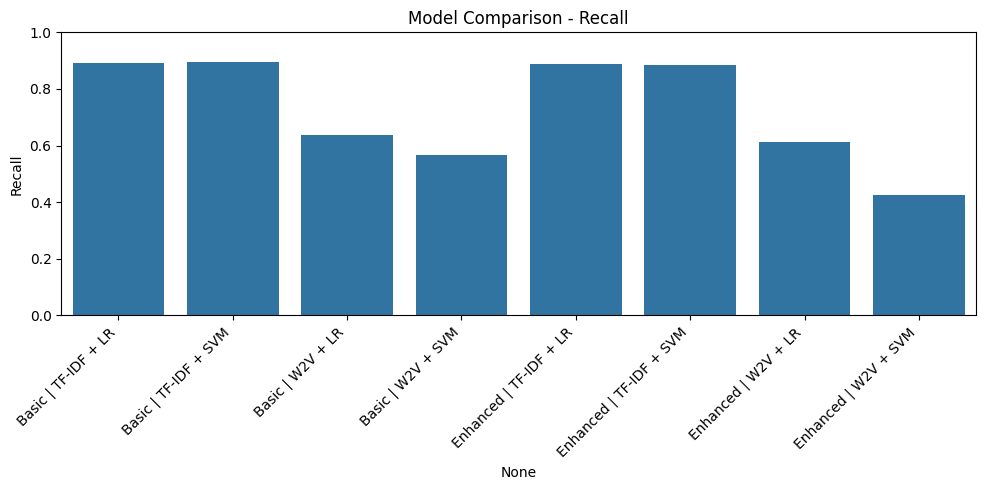

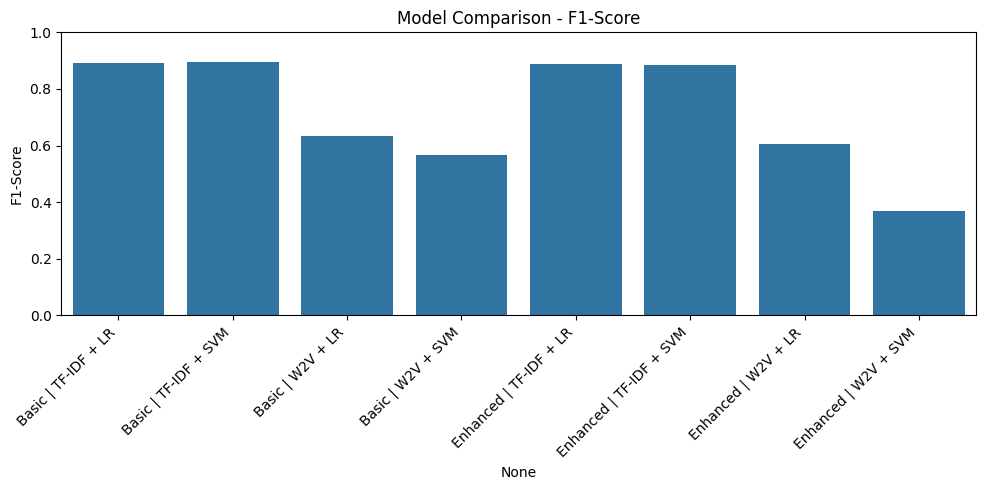

In [9]:
def plot_model_scores(df, metric_name):
    plt.figure(figsize=(10,5))
    sns.barplot(x=df.index, y=df[metric_name])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Model Comparison - {metric_name}")
    plt.ylabel(metric_name)
    plt.ylim(0.0, 1.0)
    plt.tight_layout()
    plt.show()

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    plot_model_scores(final_results, metric)